# Clean Finetuned Inference Dialogue Style


For dialogue style finetuned model, we are generated "OS-based" questions using justice specific headers. We ran 10 iterations to get 10 samples for each justice for each transcript. In this notebook, we:
1. Create a combined csv with all generations across the 10 generations. Saved to `finetune/outputs/OS_questions/processed/dialogue_finetuned_8B_inference_compiled.csv`
2. Filter out generations that are not 'questions', i.e. do not contain '?' in it or are not at least 50 chars long. Saved to `finetune/outputs/OS_questions/processed/dialogue_finetuned_8B_filtered_questions.csv`

In [11]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
base_dir = '../outputs/OS_questions'
output_csv = '../outputs/OS_questions/processed/dialogue_finetuned_8B_inference_compiled.csv'

all_rows = []

# Iterate through subdirectories and combined responses across all iterations
for i in range(1, 11):
    iter_dir = os.path.join(base_dir, f'iter_{i}')
    jsonl_path = os.path.join(iter_dir, '2024_petitioner_resps_dialogue_style_all_justices.jsonl')

    if not os.path.exists(jsonl_path):
        print(f"File not found: {jsonl_path}")
        continue

    with open(jsonl_path, 'r', encoding='utf-8') as f:
        for line in f:
            data = json.loads(line)
            responses = data.get('responses', [])
            for response in responses:
                row = {
                    'transcript_id': response.get('transcript_id', ''),
                    'question_addressee': response.get('question_addressee', ''),
                    'justice': response.get('justice', ''),
                    'opening_statement': response.get('opening_statement', ''),
                    'question_text': response.get('question_text', ''),
                    'full_response': response.get('full_response', ''),
                }
                all_rows.append(row)

df = pd.DataFrame(all_rows)
df.to_csv(output_csv, index=False)

print(f"Saved combined DataFrame to {output_csv}")

Saved combined DataFrame to ../outputs/OS_questions/processed/dialogue_finetuned_8B_inference_compiled.csv


In [3]:
df.head()

,transcript_id,question_addressee,justice,opening_statement,question_text,full_response
0,2024.23-852,petitioner,justice_amy_coney_barrett,"Mr. Chief Justice, and may it please the Cour...","General Prelogar, do you have any response to ...",<|begin_of_text|><|begin_of_text|><|start_head...
1,2024.23-852,petitioner,justice_brett_m_kavanaugh,"Mr. Chief Justice, and may it please the Cour...","I'm sorry, General.",<|begin_of_text|><|begin_of_text|><|start_head...
2,2024.23-852,petitioner,justice_clarence_thomas,"Mr. Chief Justice, and may it please the Cour...",What's the point of the requirement that the s...,<|begin_of_text|><|begin_of_text|><|start_head...
3,2024.23-852,petitioner,justice_elena_kagan,"Mr. Chief Justice, and may it please the Cour...","Mr. Prelogar, I guess I'm just trying to under...",<|begin_of_text|><|begin_of_text|><|start_head...
4,2024.23-852,petitioner,justice_john_g_roberts_jr,"Mr. Chief Justice, and may it please the Cour...","Counsel, what is the number of firearms that a...",<|begin_of_text|><|begin_of_text|><|start_head...


In [6]:
def filter_questions(text):
    # Filter out data heuristically: >50 chars and has a '?' char to indicate a justice question.
    if not text:
        return False
    return len(text) > 50 and "?" in text and "inaudible" not in text.lower()

In [7]:
df['is_question'] = df['question_text'].apply(filter_questions)

In [8]:
df['is_question'].value_counts()

is_question
True     1345
False     995
Name: count, dtype: int64

In [9]:
print(f"Percentage filtered out: {579/len(df) * 100}")

Percentage filtered out: 24.743589743589745


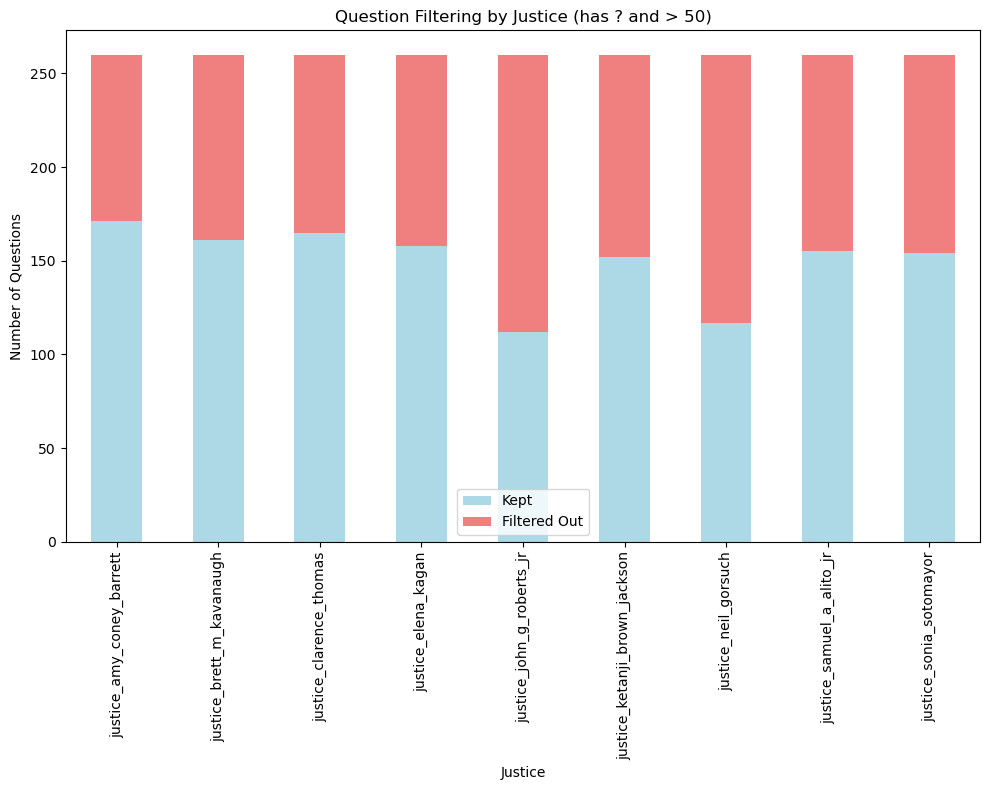

In [14]:
# Group by justice and question status
justice_grouped = df.groupby(['justice', 'is_question']).size().unstack(fill_value=0)

# Rename columns for readability
justice_grouped.columns = ['Filtered Out', 'Kept']

# Reorder columns so kept is on bottom in the stacked bar
justice_grouped = justice_grouped[['Kept', 'Filtered Out']]
colors = ['lightblue', 'lightcoral'] 

# Plot as stacked bar chart
justice_grouped.plot(kind='bar', stacked=True, figsize=(10, 8), color=colors)
plt.title('Question Filtering by Justice (has ? and > 50)')
plt.ylabel('Number of Questions')
plt.xlabel('Justice')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('filtered_questions_by_justice.png')
plt.show()

In [13]:
out_fp = '../outputs/OS_questions/processed/dialogue_finetuned_8B_filtered_questions.csv'
df.to_csv(out_fp, index=False)